In [12]:
#DEF VGG

from collections import namedtuple

import torch
import torch.nn as nn
from torchvision import models, datasets, transforms

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch.utils.data import DataLoader
import pytorch_lightning as pl

class Vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, num_classes=1000,pretrained=True):
        super(Vgg16, self).__init__()
        self.model = models.vgg16(pretrained=pretrained)
        self.model.classifier[6].out_features = num_classes
        if not requires_grad:
            for param in self.model.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x,1)
        x = self.model.classifier(x)
        return x

In [14]:
import torch

In [15]:
!conda list

# packages in environment at /home/inilab/miniconda3/envs/torch:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
attrs                     19.3.0                   pypi_0    pypi
backcall                  0.1.0                    pypi_0    pypi
bleach                    3.1.3                    pypi_0    pypi
ca-certificates           2020.1.1                      0  
certifi                   2019.11.28               py37_1  
decorator                 4.4.2                    pypi_0    pypi
defusedxml                0.6.0                    pypi_0    pypi
entrypoints               0.3                      pypi_0    pypi
importlib-metadata        1.5.0                    pypi_0    pypi
ipykernel                 5.2.0                    pypi_0    pypi
ipython                   7.13.0                   pypi_0    pypi
ipython-genutils          0.2.0                    pypi_0    pypi
ipywidgets                

In [8]:
from sklearn.metrics import accuracy_score

from collections import OrderedDict
class TestRunner(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super(pl.LightningModule, self).__init__(*args, **kwargs)
        
        self.vgg = Vgg16(requires_grad=False,num_classes=6,pretrained=True)
        
        #: Pointer to the logger object
        self.logger = None
        self.example_input_array = None
        
        #: Current dtype
        self.dtype = torch.FloatTensor

        self.exp_save_path = None
        
        #: The current epoch
        self.current_epoch = 0

        #: Total training batches seen across all epochs
        self.global_step = 0

        self.loaded_optimizer_states_dict = {}
        
        self.use_dp = True
        
        
    def forward(self,x):
        x = self.vgg(x)
        
        return x
    
    def training_step(self,batch,batch_idx):
        x, y= batch
        
        out = self.forward(x)
        loss = nn.functional.cross_entropy(out,y)
        
        #in DP
        
        if self.trainer.use_dp or self.trainer.use_ddp2:
            loss = loss.unsqueeze(0)
        
        tqdm_dict = {'train_loss':loss}
        
        output = OrderedDict({
            'loss':loss,
            'progress_bar':tqdm_dict,
            'log':tqdm_dict
            
        })
        
        return output
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        
        print(x,y)
        out = self.forward(x)
        loss = nn.functional.cross_entropy(out,y)

        #calc acc 
        
        labels_hat = torch.argmax(out,dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y)*1.0)

        output = OrderedDict({
            'val_loss':loss,
            'val_acc':torch.tensor(val_acc), #tensor
            
        })
        
        return output
    
    def validation_epoch_end(self, outputs):
        # OPTIONAL
        
        
#         val_acc_mean = 0.0
        
#         for output in outputs:
#             # reduce manually when using dp
#             if self.trainer.use_dp or self.trainer.use_ddp2:
#                 val_acc = torch.mean(val_acc)

#             val_acc_mean += val_acc
            
#         val_acc_mean /= len(outputs)

        print('val_epoch_end',outputs)

        avg_loss = 0.0
    
        if len(outputs) !=0:
            avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        
        tqdm_dict = {'val_loss':avg_loss}

        result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': avg_loss}
        
        return result
    
    
    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self.forward(x)
        _, y_hat = torch.max(y_hat,dim=1)
        test_acc = accuracy_score(y_hat.cpu(),y.cpu())
        
        return {'test_acc': torch.tensor(test_acc)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        
        avg_test_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        tensorboard_logs = {'avg_test_acc': avg_test_acc}
        return {'avg_test_acc': avg_test_acc, 'log': tensorboard_logs, 'progress_bar': tensorboard_logs}
    
    def configure_optimizers(self):
        
        opt = torch.optim.Adam(self.parameters(), lr=0.001)
        #sched = (opt,step_size = 30,gamma=0.1)
        #sched = ReduceLROnPlateau(opt,'min')
        return opt
    
    def train_dataloader(self):
        train_dataset = datasets.ImageFolder(root='AugData/Train/train0217',
                                             transform=transforms.ToTensor())
        train_loader = DataLoader(train_dataset,batch_size=64,shuffle=True)
        return train_loader
    
    def val_dataloder(self):
        val_dataset = datasets.ImageFolder(root='AugData/Test/test0217',
                                            transform=transforms.ToTensor())
        val_dataloader = DataLoader(val_dataset,batch_size=64,shuffle=True)
        return val_dataloader
    
    def test_dataloader(self):
        test_dataset = datasets.ImageFolder(root='AugData/Test/test0217',
                                            transform=transforms.ToTensor())
        test_loader = DataLoader(test_dataset,batch_size=16,shuffle=True)
        return test_loader
        

In [ ]:
model = TestRunner()

# most basic trainer, uses good defaults (1 gpu)
trainer = pl.Trainer(gpus=3,max_epochs = 200)    
trainer.fit(model)  

/home/inilab/.virtualenvs/torch/lib/python3.6/site-packages/pytorch_lightning/trainer/distrib_data_parallel.py:206: UserWarning: You requested multiple GPUs but did not specify a backendTrainer(distributed_backend=dp) (or ddp, ddp2)Setting distributed_backend=dp for you
  warnings.warn(m)


val_epoch_end []


In [5]:
trainer.save_checkpoint('cpt-92')

In [3]:
trainer.test(model)

NameError: name 'trainer' is not defined

In [3]:
  model = TestRunner().load_from_checkpoint('cpt-92')
trainer = pl.Trainer(gpus=1)
trainer.test(model)

----------------------------------------------------------------------------------------------------
TEST RESULTS
{'avg_test_acc': tensor(0.2361)}
----------------------------------------------------------------------------------------------------



In [3]:
trainer.save_checkpoint('cpt-22')

NameError: name 'trainer' is not defined

In [4]:
model = TestRunner.load_from_checkpoint('cpt-22')

In [5]:
model.eval()
model.freeze()

In [37]:
model.test()

AttributeError: 'TestRunner' object has no attribute 'test'

In [7]:
del model

In [11]:
import sys

sys.getsizeof(images)

72

In [5]:
import matplotlib.pyplot as plt
import numpy as np
test_dataset = datasets.ImageFolder(root='AugData/Test/test0217/',transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

model.eval()
model.freeze()
#get batch

test_iter = iter(test_loader)
images, labels = test_iter.next()
model.cuda()

results = model.forward(images.cuda())
pred = torch.max(results,1)

print(np.shape(results.unsqueeze(0)))
print(np.shape(results))

# import torchvision
# rows = 16
# columns = 2
# fig = plt.figure(figsize=(10,80))
# for i in range(32):
#     fig.add_subplot(rows,columns,i+1)
#     plt.gca().set_title(str(labels[i]) + str(predicted[i]))
#     img = images[i]
#     img = torchvision.transforms.ToPILImage()(img)
#     plt.imshow(img)
# plt.show()
# #
    
#_, pred = torch.max(results,1)






torch.Size([1, 32, 1000])
torch.Size([32, 1000])


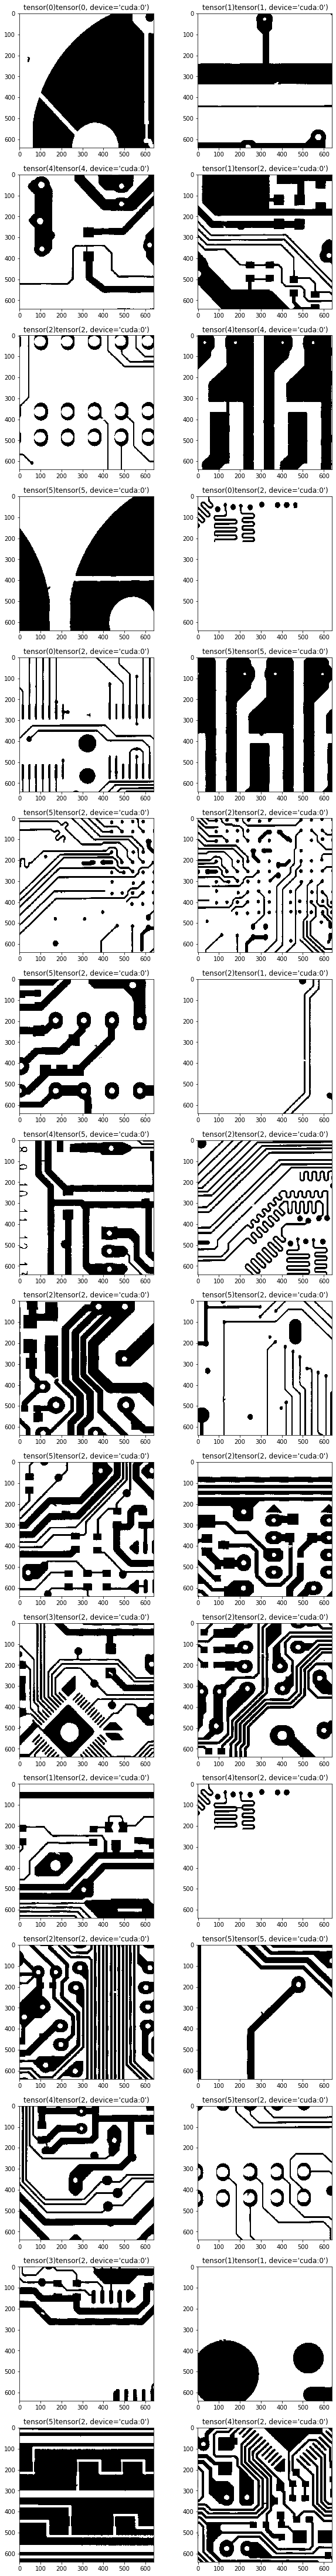

In [4]:
import matplotlib.pyplot as plt
test_dataset = datasets.ImageFolder(root='AugData/Train/train0217/',transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)


#get batch

test_iter = iter(test_loader)
images, labels = test_iter.next()
model.cuda()

results = model.forward(images.cuda())
_, predicted = torch.max(results,1)
import torchvision
rows = 16
columns = 2
fig = plt.figure(figsize=(10,80))
for i in range(32):
    fig.add_subplot(rows,columns,i+1)
    plt.gca().set_title(str(labels[i]) + str(predicted[i]))
    img = images[i]
    img = torchvision.transforms.ToPILImage()(img)
    plt.imshow(img)
plt.show()
#
    
#_, pred = torch.max(results,1)



In [9]:
images[0].size()

torch.Size([3, 640, 640])

In [16]:
model.save_checkpoint('ckt-22')


AttributeError: 'TestRunner' object has no attribute 'save_checkpoint'

In [4]:
#fast dev run 
model = TestRunner()

trainer = pl.Trainer(val_check_interval = 1,gpus=3, fast_dev_run=True)    
trainer.fit(model)  

INFO:root:
            Running in fast_dev_run mode: will run a full train,
            val loop using a single batch
            
INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0,1,2
INFO:root:
               Name               Type Params
0               vgg              Vgg16  134 M
1      vgg.features         Sequential   14 M
2    vgg.features.0             Conv2d    1 K
3    vgg.features.1               ReLU    0  
4    vgg.features.2             Conv2d   36 K
5    vgg.features.3               ReLU    0  
6    vgg.features.4          MaxPool2d    0  
7    vgg.features.5             Conv2d   73 K
8    vgg.features.6               ReLU    0  
9    vgg.features.7             Conv2d  147 K
10   vgg.features.8               ReLU    0  
11   vgg.features.9          MaxPool2d    0  
12  vgg.features.10             Conv2d  295 K
13  vgg.features.11               ReLU    0  
14  vgg.features.12             Conv2d  590 K
15  vgg.features.13               ReLU    0  
16  

TypeError: object of type 'NoneType' has no len()

In [15]:

import argparse
import os
import sys
import time
import re

import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx


In [23]:
import pytorch_lightning as pl

hparams = {'num_classes':2,}
model = TestRunner(hparams)
trainer = pl.Trainer(gpus=3)
trainer.fit()

AttributeError: 'dict' object has no attribute 'num_classes'